# Deep Learning project (Bone fractured/non fractured Classification)

# Import the data and construct DataLoaders

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import warnings

# Ignore FutureWarning and UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# DATAPATH
train_image_dir = "train"
test_image_dir = "test"
val_image_dir = "val"

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.images = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return torch.zeros(3, 224, 224), label  

In [5]:
# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets for training and test images
train_dataset = CustomDataset(train_image_dir, transform=transform)
test_dataset = CustomDataset(test_image_dir, transform=transform)
val_dataset = CustomDataset(val_image_dir, transform=transform)

# Create data loaders for training and test images
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
class_names = train_dataset.classes
class_names

['fractured', 'not fractured']

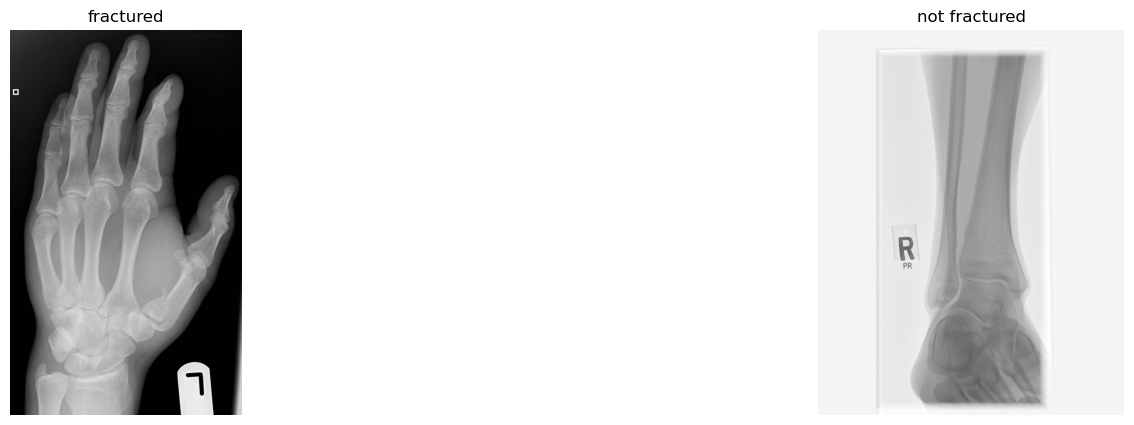

In [7]:
# Get one image per class
one_image_per_class = {}
for i, class_name in enumerate(train_dataset.classes):
    class_dir = os.path.join(train_image_dir, class_name)
    img_name = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, img_name)
    img = Image.open(img_path).convert('RGB')
    one_image_per_class[class_name] = img

# Plot one image per class
fig, axs = plt.subplots(1, len(one_image_per_class), figsize=(20, 5))
for i, (class_name, img) in enumerate(one_image_per_class.items()):
    axs[i].imshow(img)
    axs[i].set_title(class_name)
    axs[i].axis('off')

plt.show()

# Construct a Convolutional Neural Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Changed input channels to 3 for RGB images
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjusted input size after max pooling
        self.fc2 = nn.Linear(128, num_classes)  # Adjusted output size to number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the modified model
num_classes = len(class_names)  
model = CustomCNN(num_classes)


# Decide the optimizer and loss function

In [11]:
import torch.optim as optim

optimizer = optim.Adagrad(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Create a training, validation and test loop


In [20]:
from tqdm import tqdm


def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Testing
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Testing'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_acc = 100. * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies


train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10 - Testing: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch 1/10, Train Loss: 1.0003, Train Acc: 77.05%, Val Loss: 0.2612, Val Acc: 90.48%, Test Loss: 0.3357, Test Acc: 86.78%


Epoch 2/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


Epoch 2/10, Train Loss: 0.1428, Train Acc: 95.02%, Val Loss: 0.1203, Val Acc: 95.24%, Test Loss: 0.1193, Test Acc: 96.48%


Epoch 3/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


Epoch 3/10, Train Loss: 0.0473, Train Acc: 98.84%, Val Loss: 0.0830, Val Acc: 96.78%, Test Loss: 0.0553, Test Acc: 97.58%


Epoch 4/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 4/10, Train Loss: 0.0314, Train Acc: 99.22%, Val Loss: 0.0571, Val Acc: 97.55%, Test Loss: 0.0265, Test Acc: 98.90%


Epoch 5/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 5/10, Train Loss: 0.0072, Train Acc: 99.88%, Val Loss: 0.0458, Val Acc: 97.94%, Test Loss: 0.0234, Test Acc: 98.90%


Epoch 6/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Epoch 6/10, Train Loss: 0.0045, Train Acc: 99.92%, Val Loss: 0.0886, Val Acc: 97.04%, Test Loss: 0.0631, Test Acc: 98.90%


Epoch 7/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Epoch 7/10, Train Loss: 0.0033, Train Acc: 99.93%, Val Loss: 0.0499, Val Acc: 98.07%, Test Loss: 0.0277, Test Acc: 98.90%


Epoch 8/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Epoch 8/10, Train Loss: 0.0023, Train Acc: 99.96%, Val Loss: 0.0398, Val Acc: 98.71%, Test Loss: 0.0097, Test Acc: 99.78%


Epoch 9/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Epoch 9/10, Train Loss: 0.0012, Train Acc: 99.99%, Val Loss: 0.0396, Val Acc: 98.58%, Test Loss: 0.0075, Test Acc: 99.78%


Epoch 10/10 - Testing: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]

Epoch 10/10, Train Loss: 0.0009, Train Acc: 99.99%, Val Loss: 0.0407, Val Acc: 98.71%, Test Loss: 0.0079, Test Acc: 99.78%


# Visualize train, val and test accuracy 

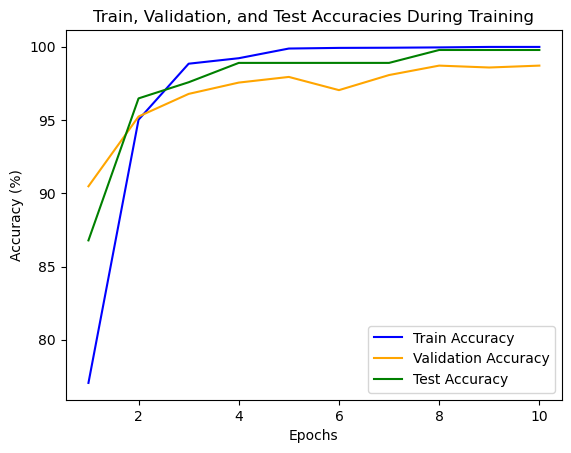

In [28]:
# Define num_epochs based on the length of train_accuracies, val_accuracies, or test_accuracies
num_epochs = len(train_accuracies)

# Visualize train, validation, and test accuracies
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='orange')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy', color='green')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train, Validation, and Test Accuracies During Training')
plt.legend()
plt.show()

# Visualize prediction images

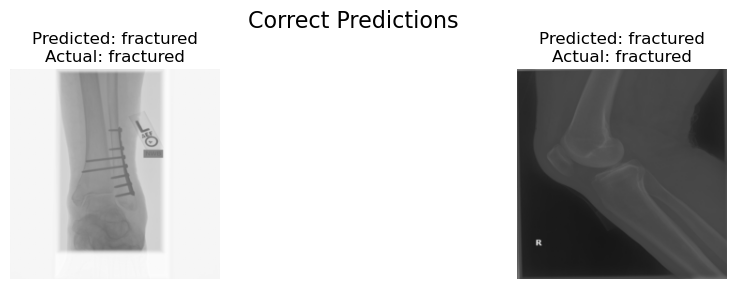

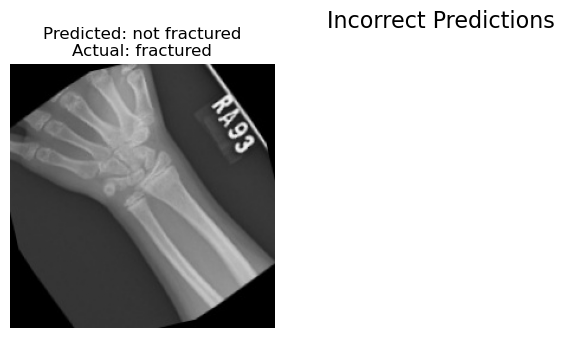

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, class_names, num_images=4, spacing=0.2):
    model.eval()
    correct_predictions = []
    incorrect_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            for j in range(len(labels)):
                predicted_class = class_names[predicted[j].item()]
                actual_class = class_names[labels[j].item()]
                if predicted[j] == labels[j]:
                    correct_predictions.append((inputs[j], predicted_class, actual_class))
                else:
                    incorrect_predictions.append((inputs[j], predicted_class, actual_class))
            
            if len(correct_predictions) >= 2 and len(incorrect_predictions) >= 2:
                break

    plt.figure(figsize=(num_images * 3, 6)) 
    plt.suptitle('Correct Predictions', fontsize=16)
    for i, (image, predicted_class, actual_class) in enumerate(correct_predictions[:num_images//2]):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(image.permute(1, 2, 0))  
        plt.title(f'Predicted: {predicted_class}\nActual: {actual_class}')
        plt.axis('off')
    
    plt.figure(figsize=(num_images * 3, 6))  
    plt.suptitle('Incorrect Predictions', fontsize=16)
    for i, (image, predicted_class, actual_class) in enumerate(incorrect_predictions[:num_images//2]):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(image.permute(1, 2, 0))  
        plt.title(f'Predicted: {predicted_class}\nActual: {actual_class}')
        plt.axis('off')
    
    plt.tight_layout(pad=spacing)  
    plt.show()

# Visualize 2 correct predictions and 2 incorrect predictions on a batch of data from your test_loader
visualize_predictions(model, test_loader, class_names, num_images=4)


# Create a confusion matrix and classification report

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

# Get all predictions and ground truth labels
all_predictions, all_labels = evaluate_model(model, test_loader)

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Create classification report
class_names = [str(i) for i in range(num_classes)]  # Assuming class labels are integers
class_report = classification_report(all_labels, all_predictions, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[237   1]
 [  0 216]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       216

    accuracy                           1.00       454
   macro avg       1.00      1.00      1.00       454
weighted avg       1.00      1.00      1.00       454

